# Piloto de Detección de Grietas usando Telegram

Autor: Gabriel San Martín Silva

Contacto: g.sanmartin.silva@gmail.com

In [1]:
# importar librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import tensorflow as tf 
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
import glob
import numpy as npx
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img


## Lectura y preprocesamiento de los datos

In [2]:
# Función que carga las imagenes y asigna la etiqueta en función al nombre de la imagen.
# Input: ruta de la carpeta que contiene imagenes.
# Output: dos numpy arrays, uno para las imagenes y otro para las etiquetas.

def Load_files(folder):
    print('\nAnalizando {}'.format(folder))
    # Read the image folder. glob.glob return a list in which the elements are the direction of the files in the folder.
    files = glob.glob(folder+'/*')
    print('Se encontraron {} imagenes'.format(len(files)))

    # load_img: Loads an image into PIL format 
    # img_to_array: Converts a PIL Image instance to a Numpy array.
    imgs = [img_to_array(load_img(img, target_size = (60,60),
                                  color_mode = 'grayscale'), dtype='float32') for img in files]
    # convert train_imgs from a list to an array
    imgs = np.asarray(imgs)/255.
    print(imgs.shape)

    # recover labels. The label is in the file name and can be either undamaged or crack
    labels = []
    for file in files:
        if 'undamaged' in file.lower():
            labels.append(0)
        elif 'crack' in file.lower():
            labels.append(1)
        else:
            'ERROR!'
            break
    labels = np.asarray(labels)
    print('Se hicieron {} labels'.format(len(labels)))
    
    return imgs, labels
    


In [3]:
# Usar la función para cargar los datos

x_train, y_train = Load_files('data/training_data')
x_test, y_test = Load_files('data/test_data')


# crear set de validacion a partir de los datos de entrenamiento
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Obtener datos de la imagen para montar la CNN
H = x_train.shape[1]
W = x_train.shape[2]
C = x_train.shape[3]


Analizando data/training_data
Se encontraron 3000 imagenes
(3000, 60, 60, 1)
Se hicieron 3000 labels

Analizando data/test_data
Se encontraron 1000 imagenes
(1000, 60, 60, 1)
Se hicieron 1000 labels


In [4]:
# Chequear el balance de las clases (siempre es importante!)

print('Train: {} % of class 0'.format(np.mean(y_train)*100))
print('Test: {} % of class 0'.format(np.mean(y_test)*100))

Train: 49.45833333333333 % of class 0
Test: 50.0 % of class 0


## Montar la red convolucional

Para este proyecto se usa una CNN relativamente simple de dos capas convolucionales y dos capas fully connected.

In [5]:
model_name = 'CNN'
#################### MODEL CNN ########################
model = tf.keras.Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(H, W, C)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(4, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
            metrics=['accuracy'])

print(model.summary())

####################################################

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 58, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 4)         292       
_________________________________________________________________
flatten (Flatten)            (None, 2916)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                186688    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

## Entrenamiento de la red

In [6]:
start = time.time()



model_history = model.fit(x_train, y_train,
                          validation_data = (x_val, y_val),
                          batch_size = 256, epochs = 75, verbose = 1)



total_time = time.time()-start
    
   

Train on 2400 samples, validate on 600 samples
Epoch 1/75
2400/2400 [==============================] - 3s 1ms/sample - loss: 0.6922 - accuracy: 0.5200 - val_loss: 0.6907 - val_accuracy: 0.5200
Epoch 2/75
2400/2400 [==============================] - 0s 92us/sample - loss: 0.6857 - accuracy: 0.5163 - val_loss: 0.6684 - val_accuracy: 0.7667
Epoch 3/75
2400/2400 [==============================] - 0s 88us/sample - loss: 0.6306 - accuracy: 0.7279 - val_loss: 0.5681 - val_accuracy: 0.7700
Epoch 4/75
2400/2400 [==============================] - 0s 88us/sample - loss: 0.5303 - accuracy: 0.7588 - val_loss: 0.4443 - val_accuracy: 0.7983
Epoch 5/75
2400/2400 [==============================] - 0s 88us/sample - loss: 0.3953 - accuracy: 0.8333 - val_loss: 0.3033 - val_accuracy: 0.8867
Epoch 6/75
2400/2400 [==============================] - 0s 88us/sample - loss: 0.2709 - accuracy: 0.9150 - val_loss: 0.2310 - val_accuracy: 0.9350
Epoch 7/75
2400/2400 [==============================] - 0s 87us/sample -

## Evaluación de los resultados sobre el test de entrenamiento y testeo para identificar un posible overfitting.

In [7]:
 
### PREDICTIONS
y_pred_train = np.where(model.predict(x_train)>0.5, 1, 0)
y_pred_test = np.where(model.predict(x_test)>0.5, 1, 0)



# accuracy
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

# balanced accuracy
bacc_train = balanced_accuracy_score(y_train, y_pred_train)
bacc_test = balanced_accuracy_score(y_test, y_pred_test)

# precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')

# recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
    
# classification report
report_train = classification_report(y_train, y_pred_train)
report_test = classification_report(y_test, y_pred_test)



print('\nTRAIN')
print('ACCURACY: {:.3f} '.format(acc_train))
print('RECALL: {:.3f} '.format(recall_train))
print('PRECISION: {:.3f} '.format(precision_train))

print('\nTEST')
print('ACCURACY: {:.3f} '.format(acc_test))
print('RECALL: {:.3f} '.format(recall_test))
print('PRECISION: {:.3f} '.format(precision_test))

print('\nTIME')
print('Time: {:.3f}  [min]'.format(total_time/60))


TRAIN
ACCURACY: 1.000 
RECALL: 1.000 
PRECISION: 1.000 

TEST
ACCURACY: 0.987 
RECALL: 0.987 
PRECISION: 0.987 

TIME
Time: 0.313  [min]


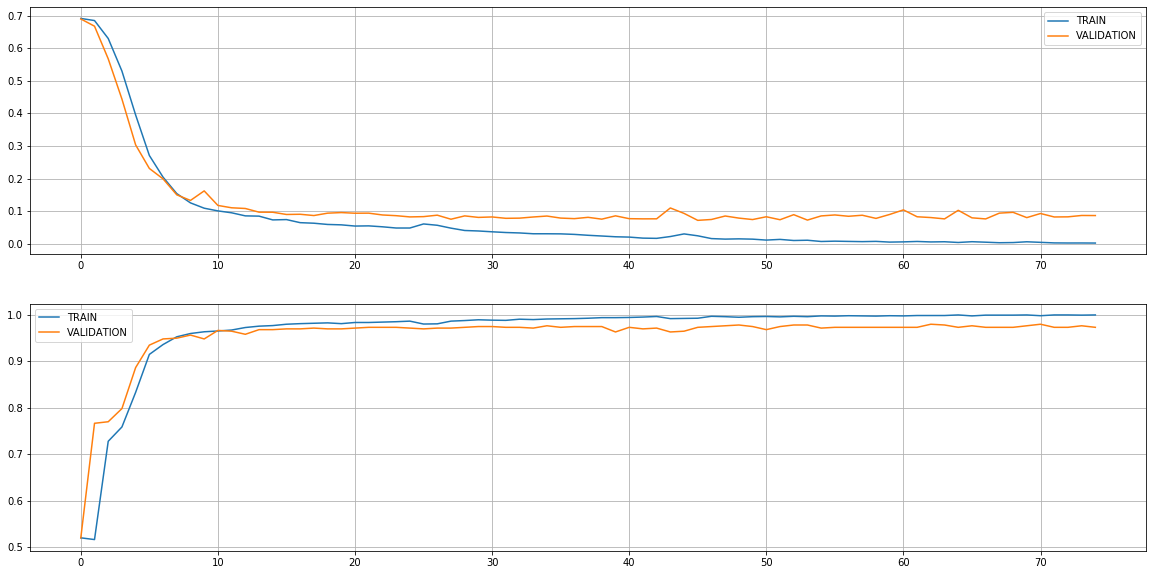

In [8]:
### Plots de las curvas de entrenamiento para el costo y el accuracy.
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.figure(figsize = (20,10))
# plot1
plt.subplot(2,1,1)
plt.plot(loss, label = 'TRAIN')
plt.plot(val_loss, label = 'VALIDATION')
plt.legend()
plt.grid()
# plot2
plt.subplot(2,1,2)
plt.plot(acc, label = 'TRAIN')
plt.plot(val_acc, label = 'VALIDATION')
plt.legend()
plt.grid()
plt.show()




## Guardar el modelo en formato `.h5`, para su lectura en TensorFlow

In [9]:
model.save('models/model_cnn.h5')

## Importar el modelo y ejecutarlo sobre una "nueva imagen" para verificar si se guardó bien y cuánto se demora en procesar.

In [10]:
from tensorflow import keras

# Recreate the exact same model purely from the file
new_model = keras.models.load_model('models/model_cnn.h5')

In [11]:
# lets see how much time it take to process one image from the test set

start = time.time()
pred = new_model.predict(x_test[0:1:,:,:,:])
print('class {}'.format(np.where(pred>0.5, 1, 0)))
print('True class {}'.format(y_test[0]))
print('time: {} s'.format(time.time()-start))

class [[1]]
True class 1
time: 0.14365100860595703 s
